## Harnessing Power of Hybrid Regularization with CIFAR-10 Dataset

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, ActivityRegularization, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10

#hybrid regularization layer
class HybridRegularization(tf.keras.layers.Layer):
    def __init__(self, loss_thresholds=[0.7, 0.3], dropout_rate=0.5, l2_lambda=0.01):
        super(HybridRegularization, self).__init__()
        self.loss_thresholds = loss_thresholds
        self.dropout = Dropout(dropout_rate)
        self.l2_lambda = l2_lambda
        self.batch_norm = BatchNormalization()
        self.l2_layer = ActivityRegularization(l2=l2_lambda)  # Keras activity regularization layer

    def call(self, inputs, training=False, loss_value=0.0):
        # Conditional logic based on loss value
        if loss_value > self.loss_thresholds[0]:  # High loss: apply L2 regularization
            inputs = self.l2_layer(inputs)  # Use Keras' ActivityRegularization for L2
        elif self.loss_thresholds[0] >= loss_value > self.loss_thresholds[1]:  # Medium loss: apply Dropout
            inputs = self.dropout(inputs, training=training)
        else:  # Low loss: apply Batch Normalization
            inputs = self.batch_norm(inputs, training=training)
        return inputs



In [5]:
def create_model_with_hybrid(input_shape):
    model = tf.keras.Sequential()

    # Add convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening layer
    model.add(Flatten())

    # Dense layers with hybrid regularization
    model.add(Dense(256, activation='relu'))
    hybrid_layer = HybridRegularization()  # Add Hybrid Regularization Layer
    model.add(hybrid_layer)

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    return model

# Complex CNN without Hybrid Regularization
def create_normal_model(input_shape):
    model = tf.keras.Sequential()

    # Add convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening layer
    model.add(Flatten())

    # Dense layers without hybrid regularization
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    return model

# Custom callback to monitor loss for hybrid regularization
class LossMonitor(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        loss_value = logs['loss']  # Get the current batch loss
        for layer in self.model.layers:
            if isinstance(layer, HybridRegularization):
                # Call the layer and pass the current loss value
                layer.call(self.model.layers[0].output, training=True, loss_value=loss_value)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'hybrid_regularization_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/10
1563/1563 - 181s - 116ms/step - accuracy: 0.4436 - loss: 1.5725 - val_accuracy: 0.5526 - val_loss: 1.2687
Epoch 2/10
1563/1563 - 201s - 128ms/step - accuracy: 0.5794 - loss: 1.1934 - val_accuracy: 0.6064 - val_loss: 1.1270
Epoch 3/10
1563/1563 - 177s - 113ms/step - accuracy: 0.6385 - loss: 1.0482 - val_accuracy: 0.6028 - val_loss: 1.1581
Epoch 4/10
1563/1563 - 175s - 112ms/step - accuracy: 0.6692 - loss: 0.9525 - val_accuracy: 0.6499 - val_loss: 0.9741
Epoch 5/10
1563/1563 - 201s - 129ms/step - accuracy: 0.6912 - loss: 0.8902 - val_accuracy: 0.7298 - val_loss: 0.7871
Epoch 6/10
1563/1563 - 204s - 131ms/step - accuracy: 0.7131 - loss: 0.8459 - val_accuracy: 0.7223 - val_loss: 0.7978
Epoch 7/10
1563/1563 - 204s - 130ms/step - accuracy: 0.7270 - loss: 0.7955 - val_accuracy: 0.7598 - val_loss: 0.7077
Epoch 8/10
1563/1563 - 199s - 127ms/step - accuracy: 0.7393 - loss: 0.7583 - val_accuracy: 0.6869 - val_loss: 0.9264
Epoch 9/10
1563/1563 - 200s - 128ms/step - accuracy: 0.7540 - lo

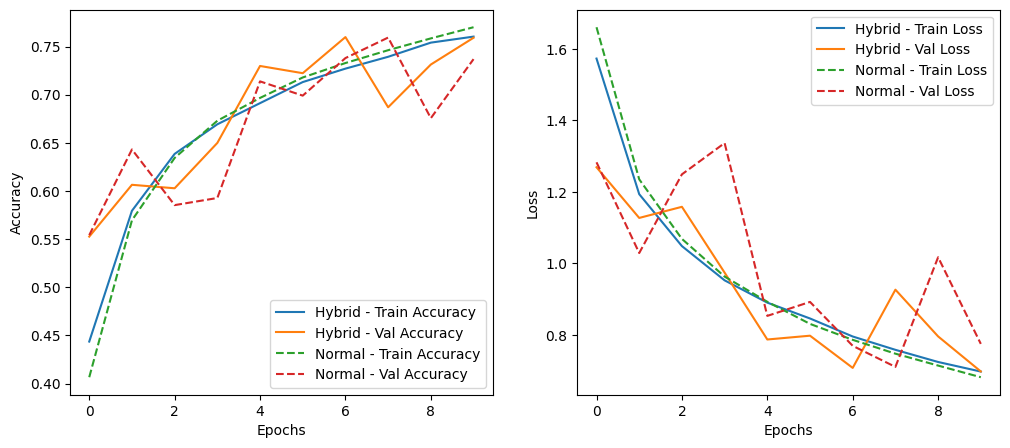

In [7]:

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to categorical (for softmax output)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

def compile_and_train(model, x_train, y_train, x_test, y_test, loss_monitor=None):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    callbacks = [loss_monitor] if loss_monitor else []
    history = model.fit(x_train, y_train, epochs=10,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks, verbose=2)
    return history

# Train model with hybrid regularization
model_hybrid = create_model_with_hybrid((32, 32, 3))
hybrid_loss_monitor = LossMonitor()
history_hybrid = compile_and_train(model_hybrid, x_train, y_train, x_test, y_test, hybrid_loss_monitor)

# Train model without hybrid regularization
model_normal = create_normal_model((32, 32, 3))
history_normal = compile_and_train(model_normal, x_train, y_train, x_test, y_test)

import matplotlib.pyplot as plt

def plot_comparison(history_hybrid, history_normal):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_hybrid.history['accuracy'], label='Hybrid - Train Accuracy')
    plt.plot(history_hybrid.history['val_accuracy'], label='Hybrid - Val Accuracy')
    plt.plot(history_normal.history['accuracy'], label='Normal - Train Accuracy', linestyle='--')
    plt.plot(history_normal.history['val_accuracy'], label='Normal - Val Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_hybrid.history['loss'], label='Hybrid - Train Loss')
    plt.plot(history_hybrid.history['val_loss'], label='Hybrid - Val Loss')
    plt.plot(history_normal.history['loss'], label='Normal - Train Loss', linestyle='--')
    plt.plot(history_normal.history['val_loss'], label='Normal - Val Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_comparison(history_hybrid, history_normal)